In [34]:
!which pip
!which python
# !pip install numpy torch scikit-learn tqdm
# !pip install pandas matplotlib torchvision IPython opencv-python opencv-contrib-python

/home/fummicc1/codes/signate/venv/bin/pip
/home/fummicc1/codes/signate/venv/bin/python


In [35]:
import os
import numpy as np
from glob import glob
import gc
import torch.distributed as dist
import pandas as pd
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as plt
from typing import List
import pathlib
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import pandas as pd
import json
from PIL.Image import Image
import PIL
from tqdm import tqdm
from PIL import ImageDraw
import engine

In [36]:
os.chdir("/workspace")

## Config

In [37]:
class Config:
    batch_size = 16
    num_classes = 10
    input_size = (800, 800)
    device = torch.device("cuda")
    
    def __init__(self) -> None:
        pass
    
config = Config()

In [38]:
def parse_json_file(label_path: str) -> pd.DataFrame:
    with open(label_path, "r") as f:
        data = json.load(f)
        
    attributes = pd.Series(data["attributes"])
    boxes = pd.DataFrame(list(map(lambda d: d["box2d"], data["labels"])))
    categories = pd.Series(list(map(lambda d: d["category"], data["labels"])))

    df = pd.DataFrame(
        data={
            "category": categories,
            "x1": boxes.x1,
            "x2": boxes.x2,
            "y1": boxes.y1,
            "y2": boxes.y2,    
        },
    )
    for (key, val) in attributes.items():
        df[key] = val
    df["image_id"] = int((label_path.split("/")[-1].split(".")[0]).replace("_", "").replace("train", ""))
    return df

## Model

In [39]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights


class CustomModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        num_classes = config.num_classes
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        self.model = model
        
    def forward(self, img, targets = [{}], train = False):
        if train:            
            return self.model(img, targets)
        else:
            return self.model(img)

In [40]:
model: CustomModel = CustomModel()
model = nn.DataParallel(model)
model.load_state_dict(torch.load("faster_rcnn_weight-1681006669.9653087.pth"))
model.to(config.device)

DataParallel(
  (module): CustomModel(
    (model): FasterRCNN(
      (transform): GeneralizedRCNNTransform(
          Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          Resize(min_size=(800,), max_size=1333, mode='bilinear')
      )
      (backbone): BackboneWithFPN(
        (body): IntermediateLayerGetter(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): FrozenBatchNorm2d(64, eps=0.0)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): FrozenBatchNorm2d(64, eps=0.0)
              (conv3): Conv2d(64, 256,

In [41]:
from PIL.Image import open as pil_open

def label_str_to_num(label: str) -> int:
    return int(label[0])

class CustomDataset(Dataset):
    def __init__(self, data: List[str], labels: List[str] = None, transform: torchvision.transforms.Compose = None, has_label: bool = False, resizing: bool = True) -> None:
        super().__init__()
        self.data = data
        self.labels = labels
        self.transform = transform
        self.has_label = has_label
        self.resizing = resizing
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index: int) -> torch.Tensor:
        image_path = self.data[index]
        img = pil_open(image_path).convert("RGB")
        # width = img.size[0]
        # height = img.size[1]
        # print(f"width: {width}, height: {height}")
        
        if not self.has_label:
            img = self.transform(img)
            return img, {}

        label_info = parse_json_file(self.labels[index])
        image_id = label_info["image_id"].values[0]
        label = torch.tensor(np.array(list(map(label_str_to_num, label_info.category.values))))        
        ratio = config.input_size[0]/max(img.size) if self.resizing else 1
        boxes = [
            # label_info.x1 * config.input_size[1] / width,
            # label_info.y1 * config.input_size[0] / height, 
            # label_info.x2 * config.input_size[1] / width + 1, 
            # label_info.y2 * config.input_size[0] / height + 1,
            label_info.x1 * ratio,
            label_info.y1 * ratio, 
            label_info.x1 * ratio + (label_info.x2 - label_info.x1) * ratio + 1, 
            label_info.y1 * ratio + (label_info.y2 - label_info.y1) * ratio + 1, 
        ]
        for i in range(len(boxes)):
            boxes[i] = torch.tensor((boxes[i]).values)
        boxes = torch.stack(boxes, dim=1)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        N = label.size()[0]
        iscrowd = torch.zeros((N, ), dtype=torch.int64)
        targets = {
            "boxes": boxes,
            "labels": label,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([image_id])            
        }
        
        if self.transform is not None:
            img = self.transform(img)
        else:
            assert False
        
        return img, targets


In [42]:
import torchvision.transforms.functional as F

def get_padding(image):    
    w, h = image.size
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2    
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    r_pad *= 2
    b_pad *= 2
    padding = (0, 0, int(r_pad), int(b_pad))
    return padding


class NewPad(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        return F.pad(img, get_padding(img), self.fill, self.padding_mode)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)

In [43]:
images_path = pathlib.Path("test") / "images" / "*.jpg"
images = list(glob(images_path.absolute().as_posix()))

In [44]:
dataset = CustomDataset(
    data=images,
    labels=None,
    transform=torchvision.transforms.Compose([
        NewPad(),
        transforms.Resize(config.input_size),
        transforms.ToTensor(),
    ]),
    has_label=False,
    resizing=True
)
dataloader = DataLoader(dataset, batch_size=config.batch_size, num_workers=8)

/tmp/ipykernel_3168392/3385415421.py:56: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_w, text_h = fnt.getsize(label)


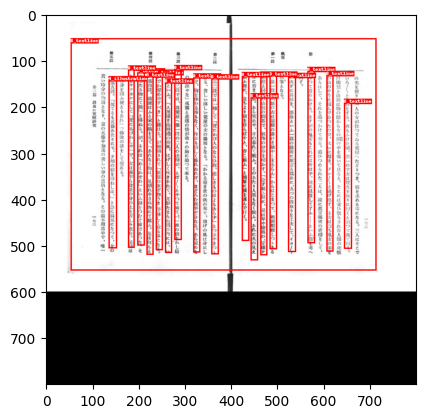

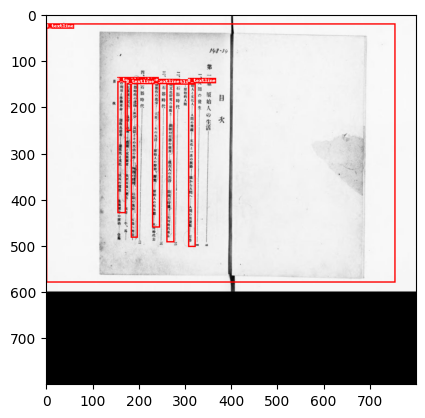

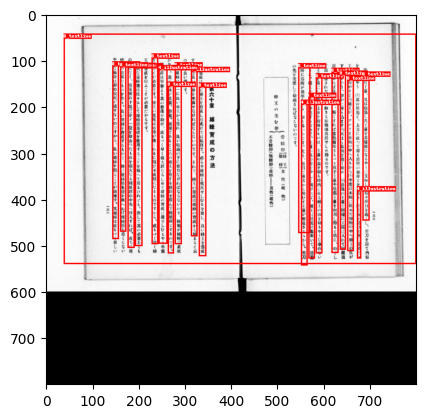

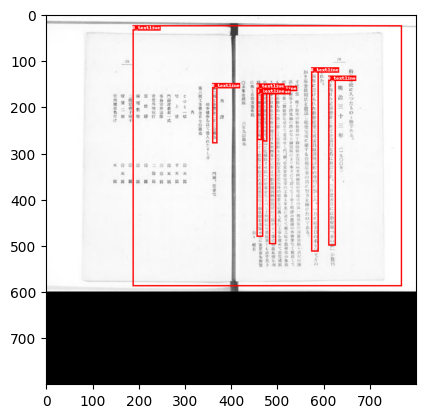

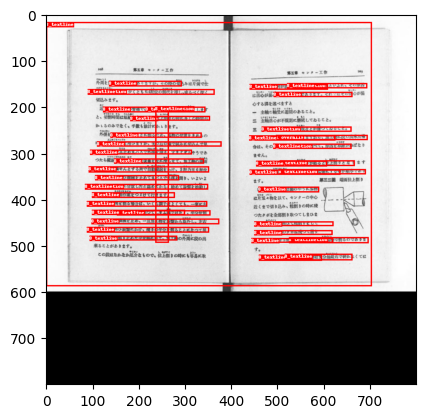

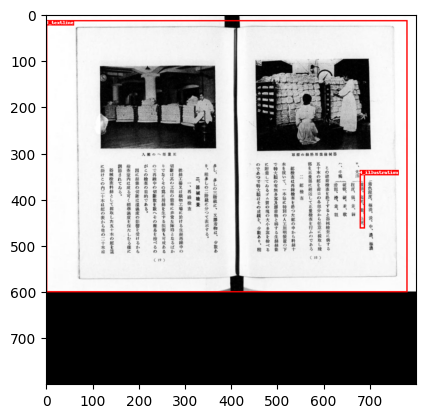

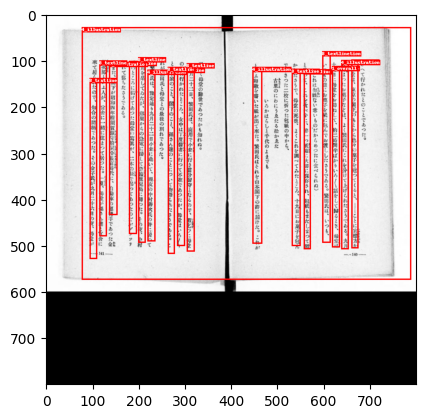

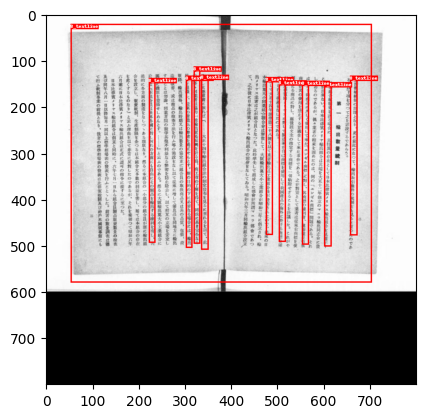

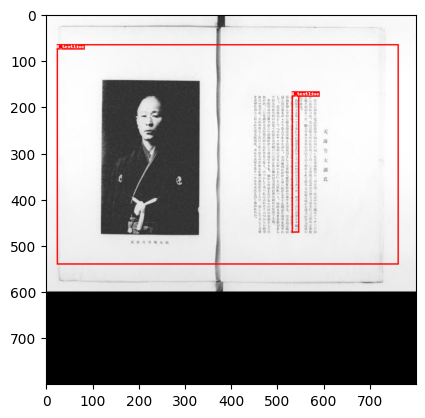

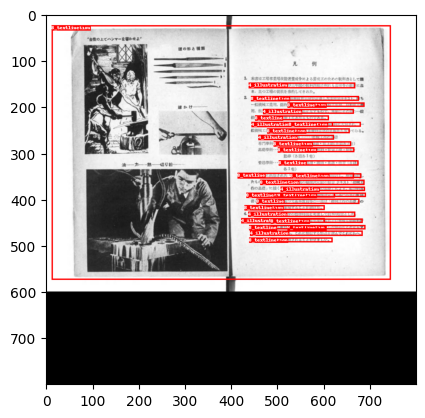

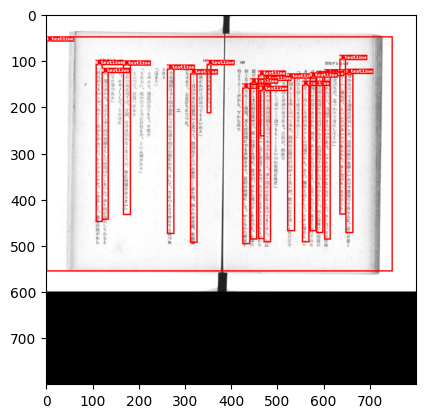

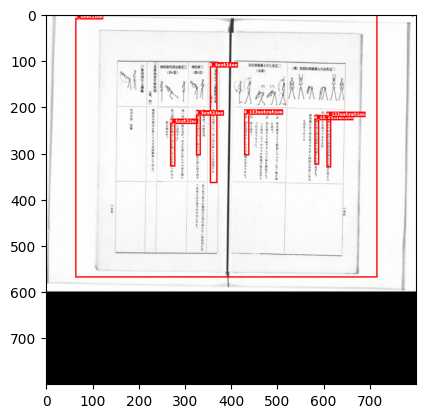

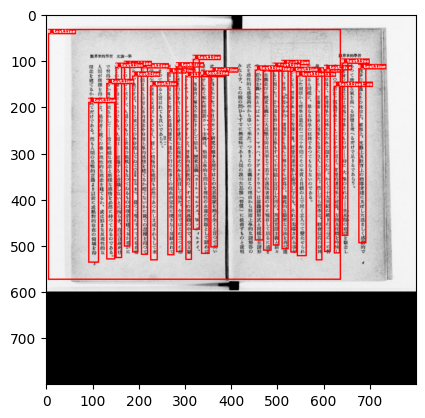

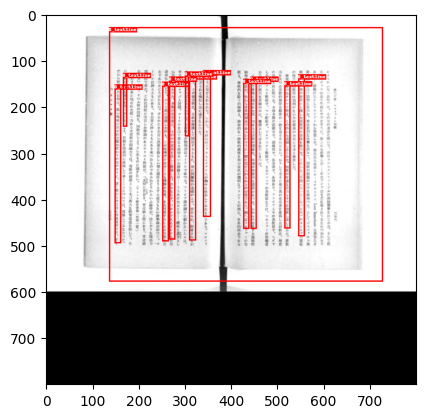

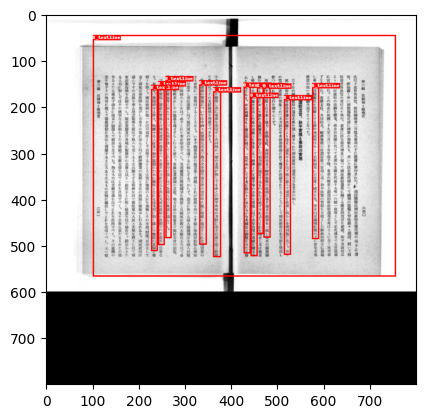

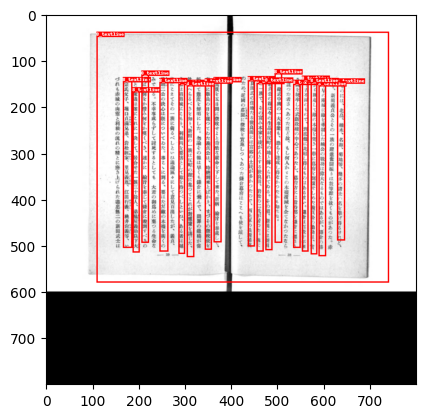

In [45]:
#結果の表示

def show(val_dataloader):
    import matplotlib.pyplot as plt
    from PIL import ImageDraw, ImageFont
    from PIL import Image
    
    #GPUのキャッシュクリア
    import torch
    torch.cuda.empty_cache()
   
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
    #device = torch.device('cpu')    
    model.to(device)
    model.eval()#推論モードへ

    images, _ = next(iter(val_dataloader))

    images = list(img.to(device) for img in images)
    
    #推論時は予測を返す
    '''
     - boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values of x
          between 0 and W and values of y between 0 and H
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction
    '''
    outputs = model(images)

    for i, image in enumerate(images):

        image = image.permute(1, 2, 0).cpu().numpy()
        image = Image.fromarray((image * 255).astype(np.uint8))

        boxes = outputs[i]["boxes"].data.cpu().numpy()
        scores = outputs[i]["scores"].data.cpu().numpy()
        labels = outputs[i]["labels"].data.cpu().numpy()

        category={0: '0_background',1:'1_overall', 2:'2_handwritten',3: '3_typography',4: '4_illustration', 5:'5_stamp', 6:'6_headline', 7:'7_caption',8: '8_textline', 9:'9_table'}



        boxes = boxes[scores >= 0.5].astype(np.int32)
        scores = scores[scores >= 0.5]

        for i, box in enumerate(boxes):
            draw = ImageDraw.Draw(image)
            label = category[labels[i]]
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

            # ラベルの表示

            from PIL import Image, ImageDraw, ImageFont 
            #fnt = ImageFont.truetype('/content/mplus-1c-black.ttf', 20)
            fnt = ImageFont.load_default()
            text_w, text_h = fnt.getsize(label)
            draw.rectangle([box[0], box[1], box[0]+text_w, box[1]+text_h], fill="red")
            draw.text((box[0], box[1]), label, font=fnt, fill='white')
            
        #画像を保存したい時用
        #image.save(f"resample_test{str(i)}.png")

        fig, ax = plt.subplots(1, 1)
        ax.imshow(np.array(image))        

    plt.show()


show(dataloader)

In [46]:
def infer():
    bar = tqdm(dataloader)
    device = config.device
    # train  
    model.eval()
    for imgs, _ in bar: 
        imgs = imgs.to(device)
        out = model(imgs)
        print(out)
        break

infer()

  0%|          | 0/26 [00:04<?, ?it/s]

[{'boxes': tensor([[197.7098, 117.7684, 213.2063, 500.7933],
        [237.3026, 121.4489, 252.1375, 510.5110],
        [565.0845, 114.4876, 581.0951, 495.3430],
        ...,
        [617.7246,  94.6627, 636.5845, 418.1334],
        [172.0420, 366.4952, 181.9306, 519.4481],
        [620.4987, 131.5270, 630.7742, 268.3807]], device='cuda:0',
       grad_fn=<GatherBackward>), 'labels': tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8,
        4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 4, 4, 8, 4, 8, 8, 8, 8, 8, 4, 8, 4, 4, 4, 4, 8, 4, 8,
        8, 8, 8, 4, 8, 1, 8, 8, 8, 8, 8, 8, 8, 4, 4, 8, 8, 4, 8, 4, 4, 8, 4, 8,
        8, 8, 8, 4, 8, 4, 4, 8, 8, 8, 8, 4, 8, 4, 8, 4